# How to spatially interpolate (Makkink) Evaporation?

Does interpolation matter? There are ways to interpolate evaporation datasets. However currently the nearest station is always used for modeling. Does this give different results? First lets look spatially.

Martin Vonk - 2022

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator, NearestNDInterpolator

import hydropandas as hpd
import hydropandas.io.io_knmi as hpdio
# import art_tools as at

Get all stations where EV24 is measured

In [2]:
stns = hpdio.get_stations(meteo_var='EV24').sort_index()

Collect all EV24 data ever measured by KNMI

In [3]:
%%time

tmin = '1900-01-01'
tmax = '2022-04-11'

# empty dataframe
df = pd.DataFrame(columns=stns.index) # index=pd.date_range(start=tmin, end=tmax, freq='H')

for stn in tqdm(stns.index):
    df_stn = hpd.MeteoObs.from_knmi(stn, meteo_var='EV24',
                                    fill_missing_obs=False, 
                                    startdate=tmin, enddate=tmax)
    df[stn] = df_stn

df

100%|██████████| 34/34 [00:18<00:00,  1.83it/s]

Wall time: 18.6 s


,210,215,235,240,242,249,251,257,260,267,...,330,344,348,350,356,370,375,377,380,391
YYYYMMDD,,,,,,,,,,,,,,,,,,,,,
1987-03-26 01:00:00,0.0006,NaN,0.0006,NaN,NaN,NaN,NaN,NaN,0.0005,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0008,NaN,NaN,0.0010,NaN
1987-03-27 01:00:00,0.0016,NaN,0.0015,NaN,NaN,NaN,NaN,NaN,0.0016,NaN,...,NaN,NaN,0.0016,NaN,NaN,0.0017,NaN,NaN,0.0024,NaN
1987-03-28 01:00:00,0.0008,NaN,0.0007,NaN,NaN,NaN,NaN,NaN,0.0007,NaN,...,NaN,NaN,0.0007,NaN,NaN,0.0005,NaN,NaN,0.0008,NaN
1987-03-29 01:00:00,0.0013,NaN,0.0007,NaN,NaN,NaN,NaN,NaN,0.0010,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0013,NaN,NaN,0.0014,NaN
1987-03-30 01:00:00,0.0019,NaN,0.0021,NaN,NaN,NaN,NaN,NaN,0.0016,NaN,...,NaN,NaN,0.0017,NaN,NaN,0.0015,NaN,NaN,0.0018,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-29 01:00:00,0.0023,0.0022,0.0020,0.0020,NaN,0.0015,0.0018,0.0014,0.0022,0.0021,...,0.0023,0.0026,0.0023,0.0018,0.0022,0.0024,0.0019,0.0025,0.0025,0.0023
2016-04-30 01:00:00,0.0023,0.0021,0.0025,0.0020,NaN,0.0022,0.0027,0.0022,0.0014,0.0021,...,0.0025,0.0021,0.0016,0.0014,0.0012,0.0015,0.0014,0.0010,0.0010,0.0009
2016-05-01 01:00:00,0.0023,0.0022,0.0029,0.0022,NaN,0.0021,0.0028,0.0026,0.0023,0.0026,...,0.0027,0.0025,0.0022,0.0021,0.0021,0.0022,0.0021,0.0009,0.0011,0.0015


Collect shape of NL (optional)

In [4]:
# nl = at.shapes.nederland().boundary

According to the KNMI, thin plate spline is the best way to interpolate Makkink evaporation. Thats also how they provide the gridded Makkink evaporation : 

- [Evaporation Dataset - gridded daily Makkink evaporation for the Netherlands](https://dataplatform.knmi.nl/dataset/ev24-2)
- [Interpolation of Makkink evaporation in the
Netherlands - Paul Hiemstra and Raymond Sluiter (2011)](https://cdn.knmi.nl/knmi/pdf/bibliotheek/knmipubTR/TR327.pdf)

100%|██████████| 6/6 [00:01<00:00,  4.73it/s]

Wall time: 1.27 s


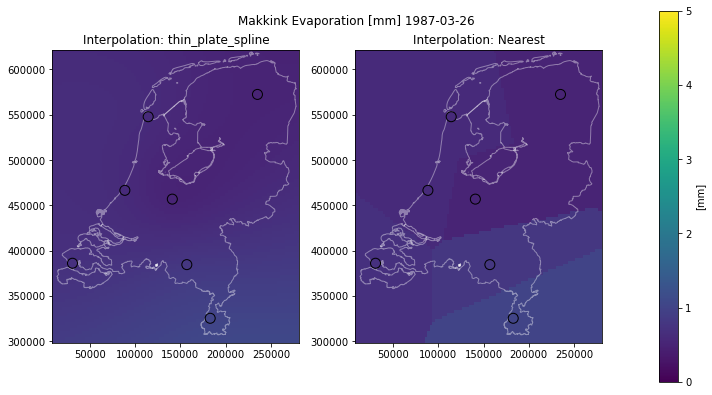

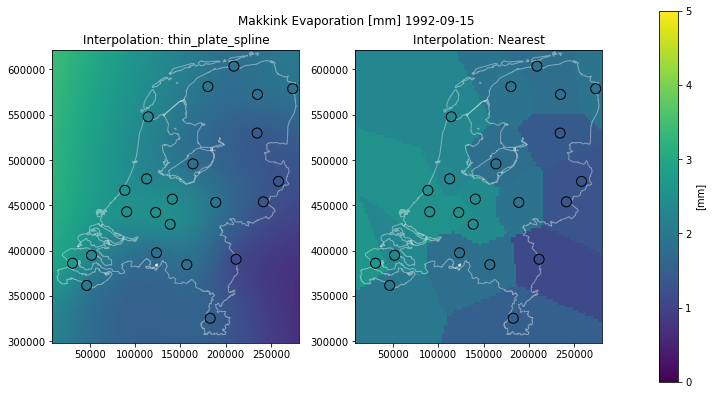

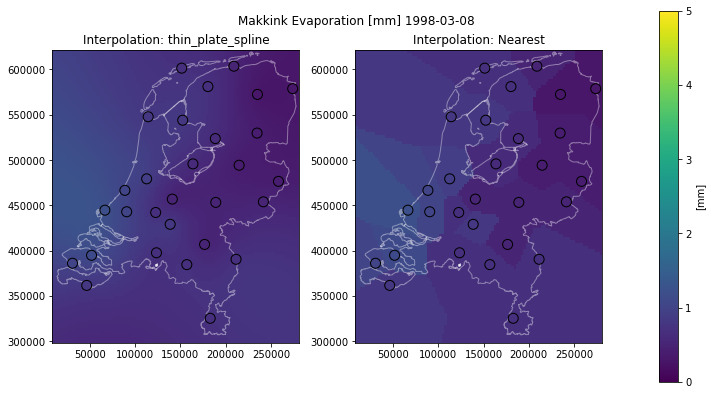

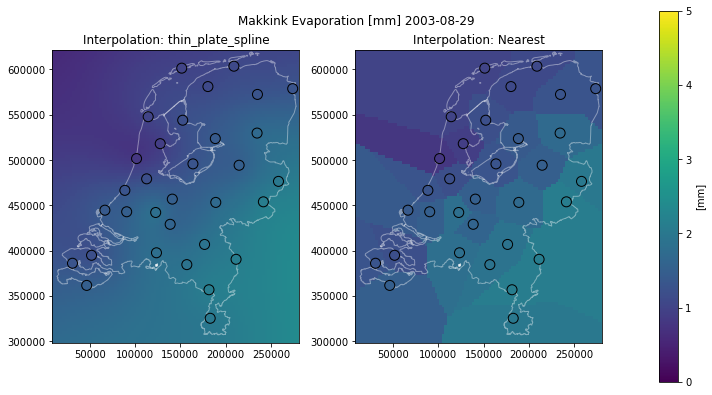

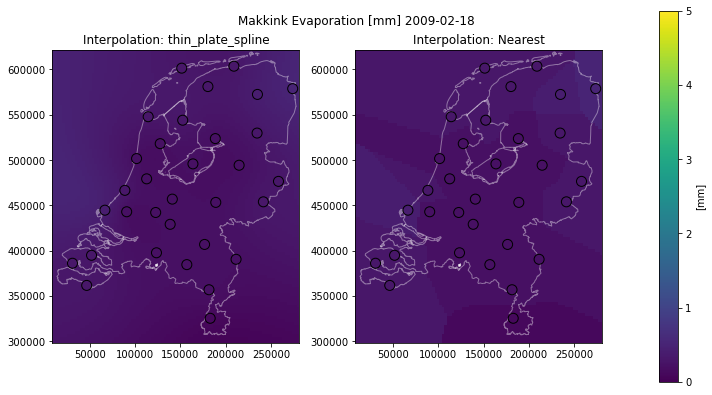

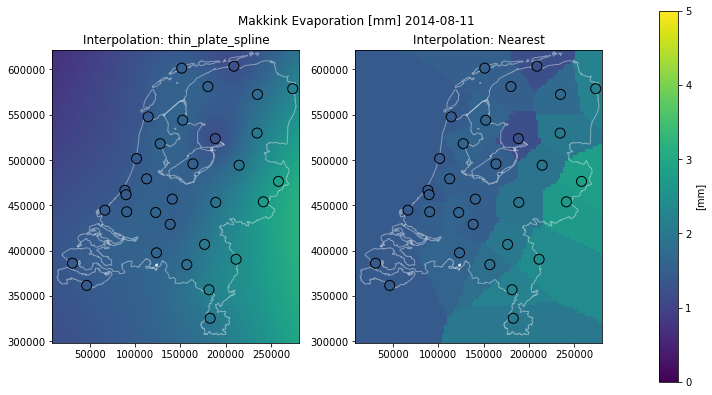

In [5]:
%%time

xy = stns.loc[df.columns, ['x', 'y']]

for idx in tqdm(df.index[0:len(df):2000]): 
    # get all stations with values for this date
    val = df.loc[idx].dropna() * 1000 #mm
    # get stations for this date
    coor = xy.loc[val.index].to_numpy()
    if len(val) < 3: # if there are less than 3 stations, thin plate spline does not work
        # options: linear, multiquadric, gaussian, 
         kernel = 'linear'

    else:
        kernel = 'thin_plate_spline' 
        # options:
        # 'inverse_quadratic', 'linear', 'multiquadric', 'gaussian', 
        # 'inverse_multiquadric', 'cubic', 'quintic', 'thin_plate_spline'

    # create an scipy interpolator
    rbf = RBFInterpolator(coor, val.to_numpy(), epsilon=1, kernel=kernel)
    
    nea = NearestNDInterpolator(coor, val.to_numpy())
    
    # interpolate on grid of the Netherlands
    grid = np.mgrid[10000:280000:100j, 300000:620000:100j]
    grid2 = grid.reshape(2, -1).T # interpolator only takes array [[x0, y0],
                                                                #  [x1, y1]]
    val_rbf = rbf.__call__(grid2).reshape(100, 100)
    val_nea = nea.__call__(grid2).reshape(100, 100)
    
    # create figure
    fig, ax = plt.subplot_mosaic('AAAABBBBC', figsize=(10,5.925))
    fig.suptitle(f'Makkink Evaporation [mm] {idx.date()}', y=0.9)
    vmin = 0
    vmax = 5

    ax['A'].set_title(f'Interpolation: {kernel}')
    ax['A'].pcolormesh(*grid, val_rbf, vmin=vmin, vmax=vmax)
    
    # nl.plot(ax=ax['A'], linewidth=1, color='w', zorder=1, alpha=0.4)

    ax['B'].set_title(f'Interpolation: Nearest')
    ax['B'].pcolormesh(*grid, val_nea, vmin=vmin, vmax=vmax)
    # nl.plot(ax=ax['B'], linewidth=1, color='w', zorder=1, alpha=0.4)
    ax['A'].scatter(*coor.T, c=val, s=100, ec='k', vmin=vmin, vmax=vmax)
    p = ax['B'].scatter(*coor.T, c=val, s=100, ec='k', vmin=vmin, vmax=vmax)
    cb = fig.colorbar(p, cax=ax['C'])
    cb.set_label('[mm]')
    fig.tight_layout()

The same method is implemented in Hydropandas and works both for one (EvaporationObs) or multiple coordinates (ObsCollection)

In [6]:
%%time
sd = '2022-01-01'
ed = '2022-04-14'
et1 = hpd.EvaporationObs.from_xy(100000, 330000, startdate=sd, enddate=ed, method='interpolation') * 1000
et1

Wall time: 4.71 s


,EV24_[100000 330000]
YYYYMMDD,
2022-01-01 01:00:00,0.256626
2022-01-02 01:00:00,0.573079
2022-01-03 01:00:00,0.325246
2022-01-04 01:00:00,0.139717
2022-01-05 01:00:00,0.156186
...,...
2022-04-10 01:00:00,2.064715
2022-04-11 01:00:00,2.256866
2022-04-12 01:00:00,2.973555


In [7]:
%%time
et2 = hpd.EvaporationObs.from_xy(100000, 330000, startdate=sd, enddate=ed, method='nearest') * 1000
et2

Wall time: 149 ms


,EV24
2022-01-01 01:00:00,0.2
2022-01-02 01:00:00,0.5
2022-01-03 01:00:00,0.4
2022-01-04 01:00:00,0.2
2022-01-05 01:00:00,0.2
...,...
2022-04-10 01:00:00,2.5
2022-04-11 01:00:00,2.6
2022-04-12 01:00:00,2.8
2022-04-13 01:00:00,2.9


As can be seen, for one location the interpolation method is significantly slower. Lets see how the values compare for a time series.

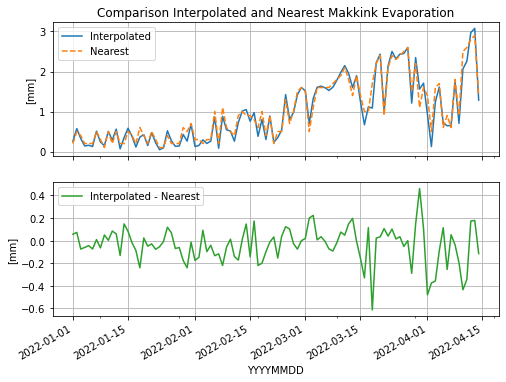

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(8,6), sharex=True)
et1.plot(ax=ax[0])
et2.plot(ax=ax[0], linestyle='--', color='C1')
ax[0].set_title('Comparison Interpolated and Nearest Makkink Evaporation')
ax[0].set_ylabel('[mm]')
ax[0].grid()
ax[0].legend(['Interpolated', 'Nearest'])

(et1.squeeze()-et2.squeeze()).plot(ax=ax[1], color='C2')
ax[1].set_ylabel('[mm]')
ax[1].grid()
ax[1].legend(['Interpolated - Nearest']);

The interpolated evaporation can also be collected for multiple points (using x and y in a list of DataFrame) in an ObsCollection

In [9]:
%%time
et3 = hpd.ObsCollection.from_knmi(xmid=[110000, 110001], ymid=[330000, 330001], meteo_vars=['EV24'], method='interpolation')
et3

Wall time: 5.3 s


,x,y,filename,station,meteo_var,obs
name,,,,,,
EV24_[110000 330000],110000,330000,,interpolation thin plate sline,EV24,-----metadata------ name : EV24_[110000 330000...
EV24_[110001 330001],110001,330001,,interpolation thin plate sline,EV24,-----metadata------ name : EV24_[110001 330001...


In [10]:
%%time
locations = pd.DataFrame({'x':{'1':110000, '2':110001}, 'y':{'1':330000, '2':330001}})
et4 = hpd.ObsCollection.from_knmi(locations, meteo_vars=['EV24'], method='interpolation')
et4

Wall time: 5.19 s


,x,y,filename,station,meteo_var,obs
name,,,,,,
EV24_[110000 330000],110000,330000,,interpolation thin plate sline,EV24,-----metadata------ name : EV24_[110000 330000...
EV24_[110001 330001],110001,330001,,interpolation thin plate sline,EV24,-----metadata------ name : EV24_[110001 330001...


Let's see how much slower the method is when collecting data for all meteostation locations in the Netherlands.

In [11]:
%%time
et5 = hpd.ObsCollection.from_knmi(stns, meteo_vars=['EV24'], method='interpolation', start='2000')
et5

Wall time: 13.8 s


,x,y,filename,station,meteo_var,obs
name,,,,,,
EV24_[ 88604. 466467.],88603.925250,466467.272114,,interpolation thin plate sline,EV24,-----metadata------ name : EV24_[ 88604. 46646...
EV24_[ 89911. 461692.],89911.000000,461692.000000,,interpolation thin plate sline,EV24,-----metadata------ name : EV24_[ 89911. 46169...
EV24_[114358. 547781.],114357.795755,547781.086192,,interpolation thin plate sline,EV24,-----metadata------ name : EV24_[114358. 54778...
EV24_[112648. 479183.],112647.908222,479183.372208,,interpolation thin plate sline,EV24,-----metadata------ name : EV24_[112648. 47918...
EV24_[123580. 583073.],123580.000000,583073.000000,,interpolation thin plate sline,EV24,-----metadata------ name : EV24_[123580. 58307...
EV24_[127643. 518017.],127642.514825,518017.433174,,interpolation thin plate sline,EV24,-----metadata------ name : EV24_[127643. 51801...
EV24_[151388. 601395.],151388.211411,601395.159806,,interpolation thin plate sline,EV24,-----metadata------ name : EV24_[151388. 60139...
EV24_[101523. 501543.],101522.987295,501543.393472,,interpolation thin plate sline,EV24,-----metadata------ name : EV24_[101523. 50154...
EV24_[141003. 456772.],141002.996557,456772.017696,,interpolation thin plate sline,EV24,-----metadata------ name : EV24_[141003. 45677...


In [12]:
%%time
et6 = hpd.ObsCollection.from_knmi(stns, meteo_vars=['EV24'], method='nearest', start='2000')
et6

Wall time: 16.6 s


,x,y,filename,station,meteo_var,obs
name,,,,,,
EV24_VALKENBURG,88603.925250,466467.272114,,210,EV24,-----metadata------ name : EV24_VALKENBURG x ...
EV24_VOORSCHOTEN,89911.000000,461692.000000,,215,EV24,-----metadata------ name : EV24_VOORSCHOTEN x...
EV24_DE-KOOY,114357.795755,547781.086192,,235,EV24,-----metadata------ name : EV24_DE-KOOY x : 1...
EV24_SCHIPHOL,112647.908222,479183.372208,,240,EV24,-----metadata------ name : EV24_SCHIPHOL x : ...
EV24_VLIELAND,123580.000000,583073.000000,,242,EV24,-----metadata------ name : EV24_VLIELAND x : ...
EV24_BERKHOUT,127642.514825,518017.433174,,249,EV24,-----metadata------ name : EV24_BERKHOUT x : ...
EV24_HOORN-TERSCHELLING,151388.211411,601395.159806,,251,EV24,-----metadata------ name : EV24_HOORN-TERSCHEL...
EV24_WIJK-AAN-ZEE,101522.987295,501543.393472,,257,EV24,-----metadata------ name : EV24_WIJK-AAN-ZEE ...
EV24_DE-BILT,141002.996557,456772.017696,,260,EV24,-----metadata------ name : EV24_DE-BILT x : 1...


Now the difference is not that significant anymore. Lets see how the time series compare at the locations of the meteostations

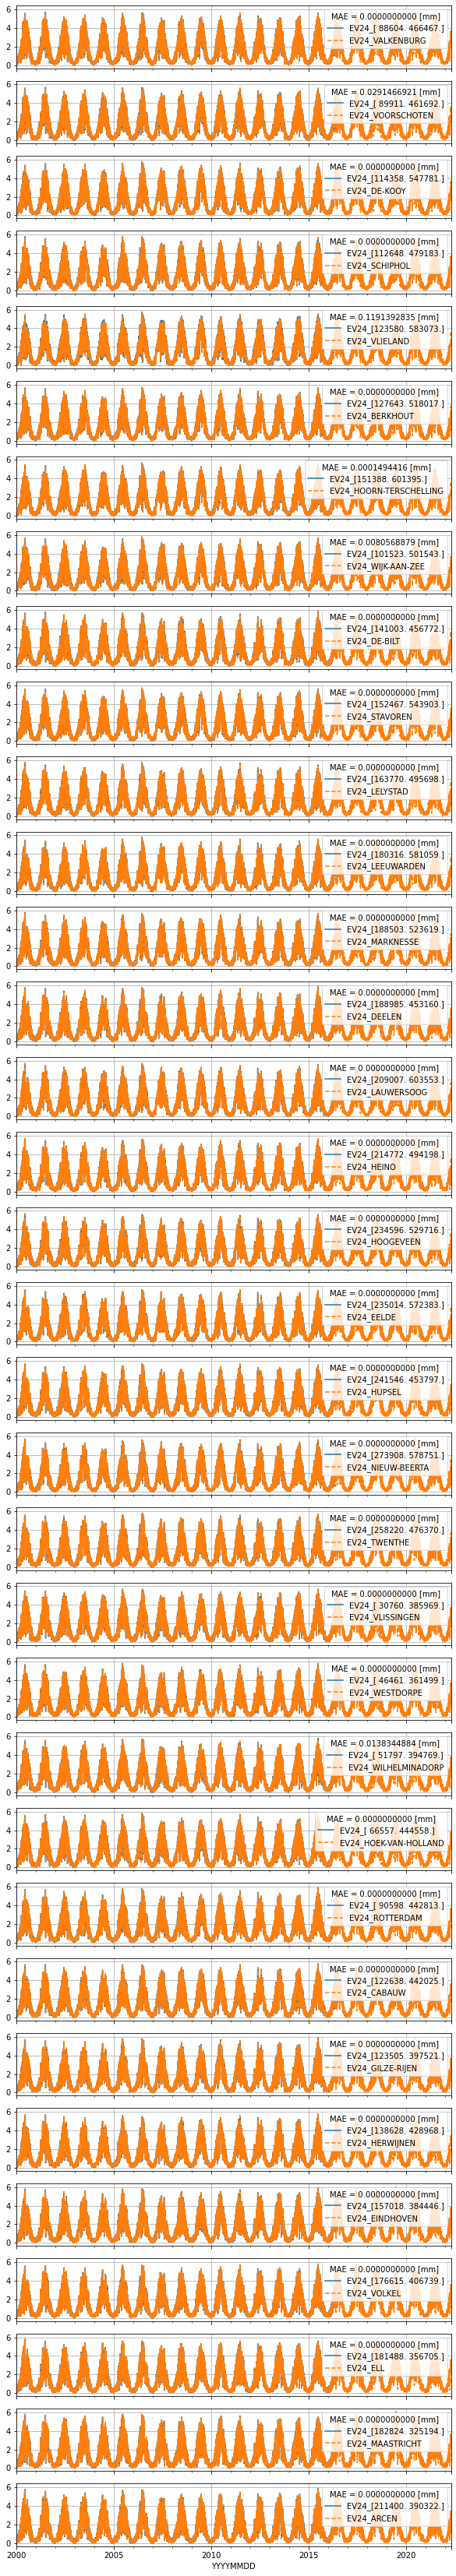

In [13]:
fix, ax = plt.subplots(len(stns.index), figsize=(10,60), sharex=True, sharey=True)
for i, (sidx, iidx, sidx) in enumerate(zip(stns.index, et5.index, et6.index)):
    ii = et5.loc[iidx, 'obs'].squeeze() * 1000
    ii.plot(ax=ax[i])
    si = et6.loc[sidx, 'obs']['EV24'].squeeze() * 1000
    si.plot(ax=ax[i], linestyle='--')
    ax[i].grid()
    ax[i].legend([iidx, sidx], title=f"MAE = {(si - ii).abs().mean():0.10f} [mm]")
    

Apparently the values at the locations of the stations are basically the same. Only differences are seen at locations where missing data is filled.